In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import keras
import sys
import os
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Flatten
from keras import Input
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

In [285]:
main_dir = os.path.dirname(sys.path[0])
main_dir

'C:\\Users\\91700\\Desktop'

In [286]:
data_link = main_dir+"/sambitml/data/flower_recognition/train/"
data_link

'C:\\Users\\91700\\Desktop/sambitml/data/flower_recognition/train/'

In [287]:
labels = set(["daisy","dandelion","rose","sunflower","tulip"])

In [288]:
image_path = []
image_labels = []

for label in labels:
    for image in list(os.listdir(data_link+label)):
        image_path = image_path + [data_link+label+'/'+image]
        image_labels = image_labels + [label]

In [289]:
data = []
data 
for img in image_path:
    image = cv2.imread(img)
    image = cv2.resize(image,(224,224))
    data.append(image)

In [290]:
X = np.array(data,dtype=float)

In [291]:
X.shape

(2746, 224, 224, 3)

In [292]:
y = np.array(image_labels)

In [293]:
y.shape

(2746,)

In [294]:
def display_image(X,y):
    fig, ax = plt.subplots(5,5,sharey=False,tight_layout=True, figsize=(12,12), facecolor='white')
    for i in range(0,5):
        for j in range(0,5):
            n = np.random.randint(0,len(y))
            ax[i,j].matshow(X[n])
            ax[i,j].set(title = y[n])
            ax[i,j].axis('off')
    plt.show()

In [347]:
def plot_acc(model_run,eps):
    plt.figure(figsize=(15,8))
    epochs = range(1,eps+1)
    train_accuracy = model_run.history['accuracy']
    val_accuracy = model_run.history['val_accuracy']
    sns.lineplot(epochs, train_accuracy, label ='Train',linewidth=1.5)
    sns.lineplot(epochs, val_accuracy, label ='validation',linewidth=1.5)
    plt.title('Accuracy v/s Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

def plot_loss(model_run,eps):
    plt.figure(figsize=(15,8))
    epochs = range(1,eps+1)
    train_loss = model_run.history['loss']
    val_loss = model_run.history['val_loss']
    sns.lineplot(epochs, train_loss, label ='Train',linewidth=1.5)
    sns.lineplot(epochs, val_loss, label ='validation',linewidth=1.5)
    plt.title('Loss v/s Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

def evaluation(model,X_test,y_test,y_test2):
    loss,accuracy = model.evaluate(X_test,y_test)
    print('loss = ',np.round(loss,5))
    print('accuracy = ',np.round(accuracy*100,2))
    
    y_pred = np.argmax(model.predict(X_test),axis=1)
    print(classification_report(y_test2,y_pred))

def predict_image(model,index,X_test,y_test,y_pred):
    
    plt.matshow(X_test[index])
    y_ind = int(y_test[index])
    labels = ["daisy","dandelion","rose","sunflower","tulip"]
    plt.title(labels[y_ind])
    
    y_ind2 = int(y_pred[index])
    print('predicted item name ::: ',labels[y_ind2])

In [296]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)

In [297]:
X_train =X_train/255.0
X_valid = X_valid/255.0

In [298]:
X_train.shape

(2196, 224, 224, 3)

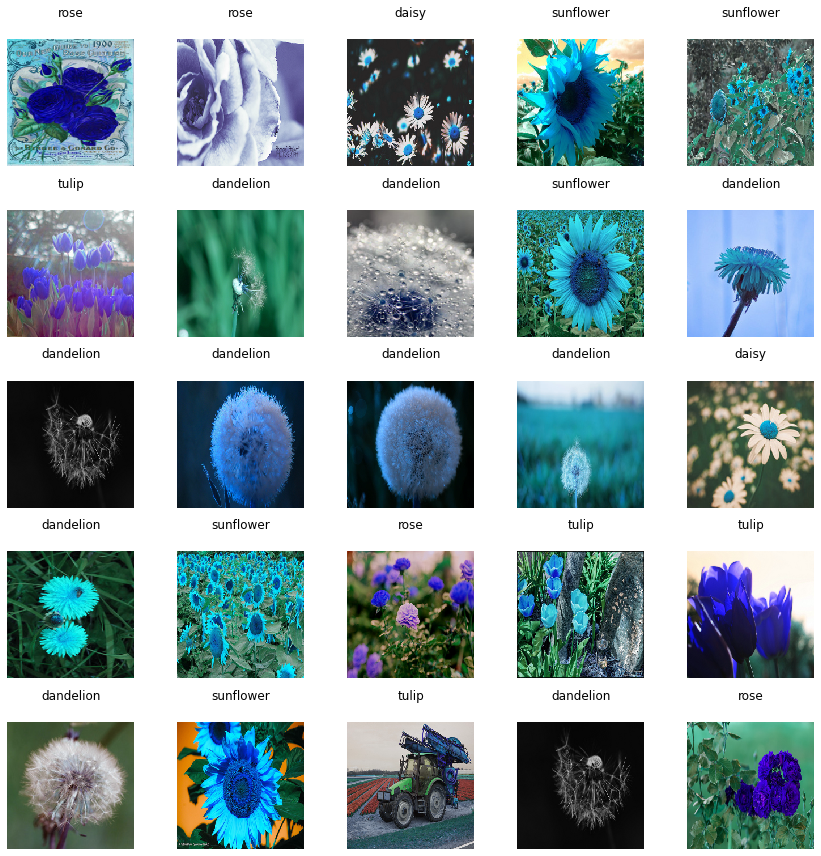

In [299]:
display_image(X_train,y_train)

In [317]:
encoder = OrdinalEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,1))
y_valid = encoder.transform(y_valid.reshape(-1,1))

In [318]:
y_valid2=y_valid

In [320]:
y_train.shape

(2196, 1)

In [316]:
y_train

array([[4.],
       [0.],
       [1.],
       ...,
       [1.],
       [2.],
       [4.]])

In [303]:
print('X_train shape :',X_train.shape)
print('X_test shape :',X_valid.shape)
print('y_train shape :',y_train.shape)
print('y_test shape :',y_valid.shape)

X_train shape : (2196, 224, 224, 3)
X_test shape : (550, 224, 224, 3)
y_train shape : (2196, 1)
y_test shape : (550, 1)


In [304]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [305]:
data_augmentation = keras.Sequential(
  [tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [335]:
X_train = data_augmentation(X_train)

In [336]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [337]:
for layer in base_model.layers:
   layer.trainable = False

In [338]:
x = Flatten()(base_model.output)
prediction = Dense(5,activation='softmax')(x)
vgg_model = tf.keras.models.Model(inputs=base_model.input,outputs=prediction)

In [339]:
vgg_model.compile(optimizer='rmsprop',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [340]:
eps = 12
history_vgg = vgg_model.fit(X_train,y_train,epochs=eps,validation_data=(X_valid,y_valid),validation_split=0.2)

Epoch 1/12
55/55 [==============================] - 485s 9s/step - loss: 1.6488 - accuracy: 0.5621 - val_loss: 1.4305 - val_accuracy: 0.5318
Epoch 2/12
55/55 [==============================] - 485s 9s/step - loss: 0.6335 - accuracy: 0.7830 - val_loss: 2.4940 - val_accuracy: 0.5886
Epoch 3/12
55/55 [==============================] - 484s 9s/step - loss: 0.4617 - accuracy: 0.8628 - val_loss: 0.6051 - val_accuracy: 0.8045
Epoch 4/12
55/55 [==============================] - 486s 9s/step - loss: 0.2248 - accuracy: 0.9186 - val_loss: 0.5903 - val_accuracy: 0.8159
Epoch 5/12
55/55 [==============================] - 492s 9s/step - loss: 0.2059 - accuracy: 0.9356 - val_loss: 0.5642 - val_accuracy: 0.8182
Epoch 6/12
55/55 [==============================] - 494s 9s/step - loss: 0.1296 - accuracy: 0.9641 - val_loss: 1.4800 - val_accuracy: 0.6750
Epoch 7/12
55/55 [==============================] - 515s 9s/step - loss: 0.0936 - accuracy: 0.9738 - val_loss: 0.7185 - val_accuracy: 0.8227
Epoch 8/12
55

In [341]:
vgg_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

C:\Users\91700\Desktop\sambitml\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\91700\Desktop\sambitml\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


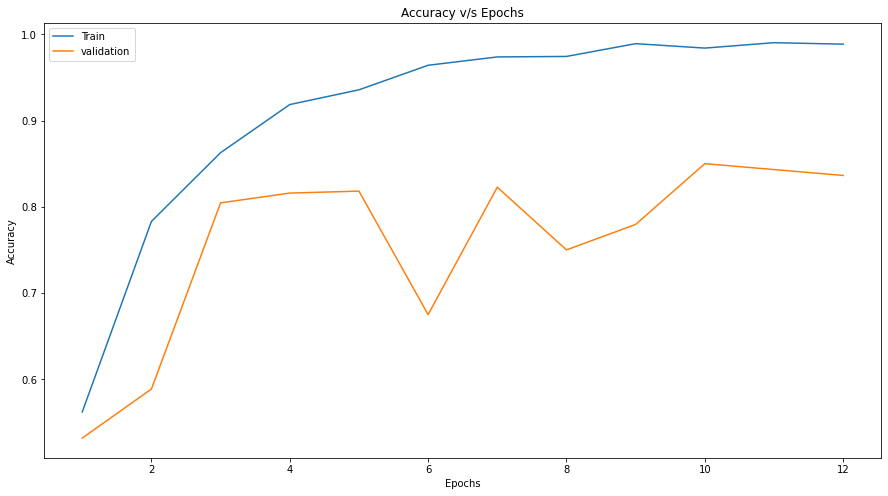

In [342]:
plot_acc(history_vgg,eps)

C:\Users\91700\Desktop\sambitml\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\91700\Desktop\sambitml\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


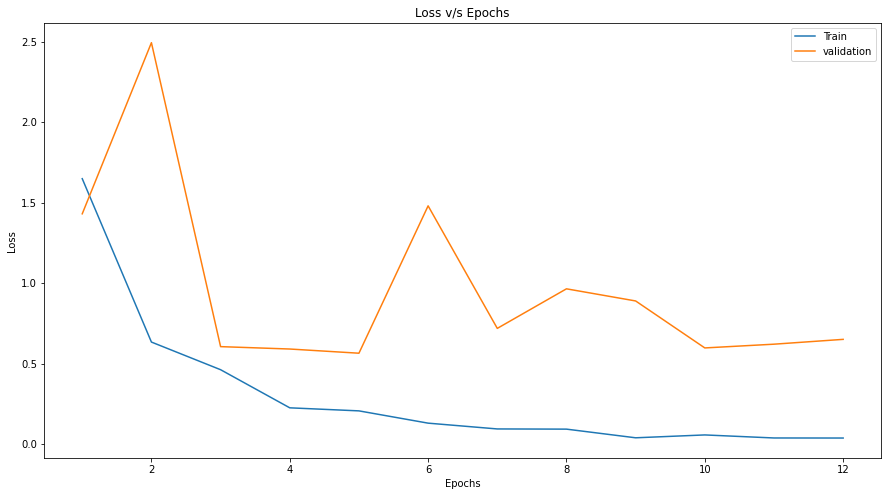

In [343]:
plot_loss(history_vgg,eps)

In [344]:
evaluation(vgg_model,X_valid,y_valid,y_valid2)

18/18 [==============================] - 156s 9s/step - loss: 0.6513 - accuracy: 0.8309
loss =  0.65132
accuracy =  83.09
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.81       107
         1.0       0.85      0.92      0.89       138
         2.0       0.83      0.80      0.81       104
         3.0       0.77      0.88      0.82        93
         4.0       0.82      0.78      0.80       108

    accuracy                           0.83       550
   macro avg       0.83      0.83      0.83       550
weighted avg       0.83      0.83      0.83       550



In [346]:
y_pred = np.argmax(model.predict(X_valid),axis=1)

predicted item name :::  rose


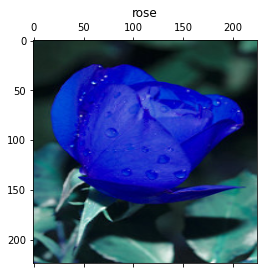

In [353]:
predict_image(vgg_model,199,X_valid,y_valid,y_pred)